# Clean notebook for attention maps

In [72]:
import os
print("CWD: ", os.getcwd())
import cortex
file_store = cortex.options.config.get('basic', 'filestore')
file_path = os.path.join(file_store, 'fsaverage', 'overlays.svg')
import numpy as np
import glob
import pylab
import pandas as pd
import time
import nibabel as nb
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
from collections import defaultdict
import seaborn as sns

CWD:  /home/hpcgies1/Masters-Thesis/AttemptFour/notebooks


In [5]:
"""
Load Glasser data
"""

GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
groups = groups_lh[1:] + groups_rh[1:]
#groups_concat = list(map(list.__add__, groups_lh, groups_rh))
groups_lh = groups_lh[1:]
groups_rh = groups_rh[1:]
assert len(groups) == 360, "Using separate hemishere groups = 360"


load glasser masks: 0.13
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


In [312]:
def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents


def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

def load_attn(file_path):
    return np.squeeze(np.load(file_path), axis=-1)

def get_attn_file(model_name):
    files = glob.glob(f"{log_dir}/{model_name}/eval_out/attention_*")
    print(model_name, "--", files[0].split("/")[-1])
    return files[0]

# Data Loader

In [326]:
log_dir = '/home/hpcgies1/rds/hpc-work/NIC/Log/'
plots_dir = '/home/hpcgies1/Masters-Thesis/AttemptFour/Plots'

In [317]:
sub1 = load_attn(get_attn_file('subject_1_layer_norm'))
sub2 = load_attn("../Log/subject_2_both_layer_norm/eval_out/attention_scores_25.npy")
sub5 = load_attn(get_attn_file('subject_5_layer_norm'))
sub7 = load_attn(get_attn_file('subject_7_layer_norm'))
# all_subs = load_attn(get_attn_file('multi_subject_torch_s1257'))
sub2_only = load_attn(get_attn_file('torch_s2'))
three_subs = load_attn(get_attn_file('multi_subject_torch_3subs'))
batch_subs = load_attn(get_attn_file('torch_alt_batches'))

subject_1_layer_norm -- attention_scores_28.npy
subject_5_layer_norm -- attention_scores_27.npy
subject_7_layer_norm -- attention_scores_28.npy
torch_s2 -- attention_scores_14.npy
multi_subject_torch_3subs -- attention_scores_14.npy
torch_alt_batches -- attention_scores_8.npy


In [402]:
batch_subs = np.load("/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/eval_out/attention_scores_8.npy")

In [403]:
batch_subs.shape

(8, 515, 15, 360, 1)

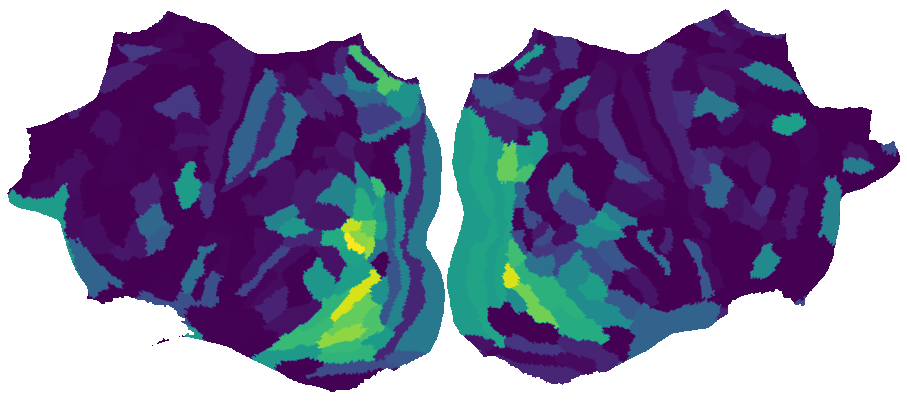

In [471]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

d = batch_subs[1]
# d = np.mean(d, axis=(0,1))
d = np.max(d, axis=(0,1))
# d = d[88,0]
# d = np.log(d)
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

plt.show()

241


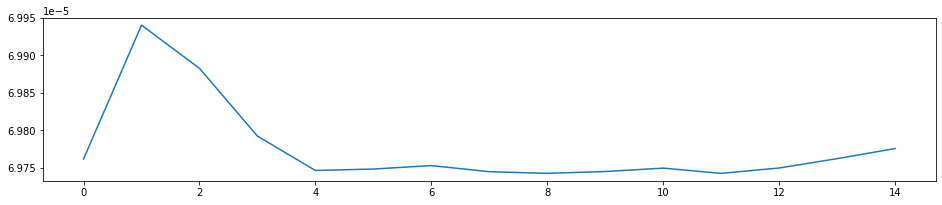

In [450]:
d = batch_subs[1]  # [515, 15, 360]

var = []
for trial in range(d.shape[0]):
    t = np.var(d[trial,:], axis=1)
    var.append(t)
var = np.array(var) # [515, 15, 1]

    
var_mean = np.mean(var, axis=0).flatten()
var_std  = np.std(var, axis=0).flatten()


plt.figure(figsize=(16,3))
plt.plot(var_mean)
# plt.errorbar(np.arange(var_mean.shape[0]), var_mean, yerr=var_std, capsize=10, color='black')

# plt.plot(var[241])

print(np.argmax(var))

plt.show()

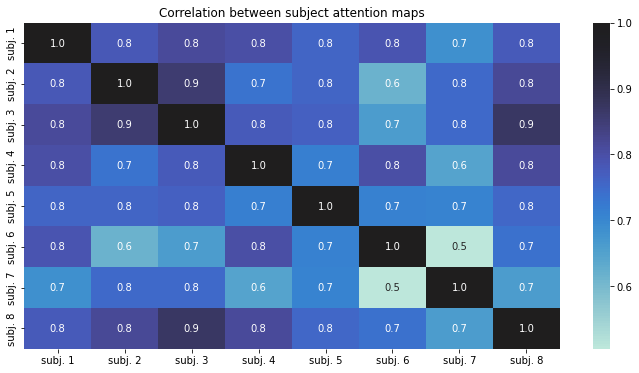

In [515]:
a = np.array([np.mean(i, axis=(0,1)) for i in np.squeeze(batch_subs, -1)]).transpose(1, 0)
a = pd.DataFrame(a, columns=[f'subj. {i}' for i in range(1, 9)])

plt.figure(figsize=(12,6))
sns.heatmap(a.corr('pearson'), center=1., annot=True, fmt='.1f')
plt.title("Correlation between subject attention maps")
# plt.savefig(f"{home_dir}/Plots/correlation_between_subs.png", bbox_inches='tight')
plt.show()

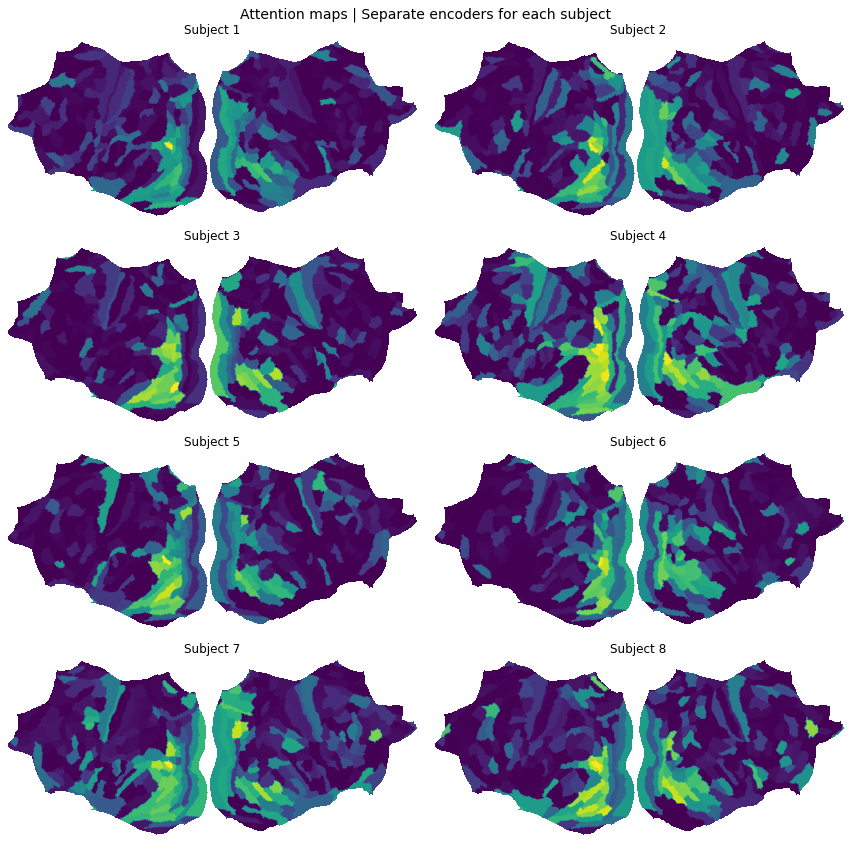

In [559]:
# 8 subjects
fig, ax = plt.subplots(4,2, figsize=(12,12))

for i, a in enumerate(ax.flatten()):
    d = batch_subs[i]
    d = np.max(d, axis=(0,1))
#     d = np.log(d)
    a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"Subject {i+1}")

plt.suptitle("Attention maps | Separate encoders for each subject", fontsize=14)
plt.tight_layout()
# plt.savefig(f"{plots_dir}/separate_encoders_mix_batches.png", bbox_inches='tight')
plt.show()

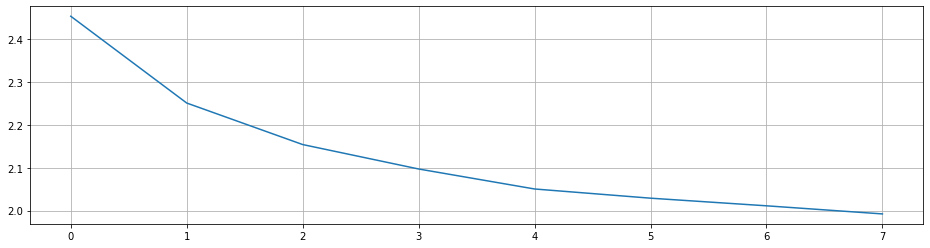

In [558]:
loss_df = pd.read_csv("/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/loss_history.csv")
loss = loss_df['loss'].values
loss = loss[-2226*8:]
val_loss = loss_df['val_loss'].values
val_loss = val_loss[-2304*8:]
# loss = loss[np.isfinite(loss)]
plt.figure(figsize=(16,4))
plt.grid()

def group_by_nan(a):
    """ Split 1D array on nan values """
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

loss = using_clump(loss)
loss = [np.mean(i) for i in loss]
val_loss = using_clump(val_loss)
val_loss = [np.mean(i) for i in val_loss]
plt.plot(val_loss)

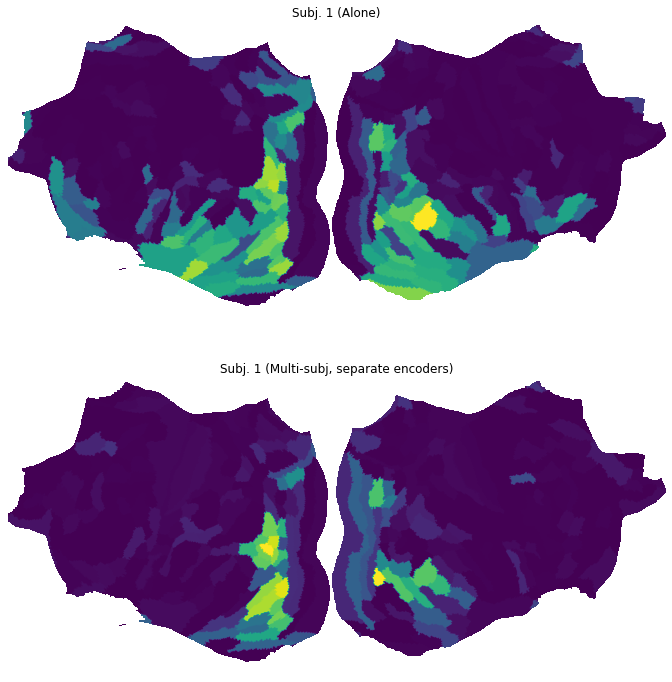

In [518]:
fig, ax = plt.subplots(2,1, figsize=(12,12))


d = np.mean(sub1, axis=(0,1))
ax[0].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[0].axis('off')
ax[0].set_title("Subj. 1 (Alone)")

d = np.mean(batch_subs[0], axis=(0,1))
ax[1].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[1].axis('off')
ax[1].set_title("Subj. 1 (Multi-subj, separate encoders)")

plt.show()

### Captions


In [328]:
keys = pd.read_csv(f'/home/hpcgies1/Masters-Thesis/AttemptFour/TrainData/subj02_conditions2.csv')
keys = keys.loc[keys['is_test'] == 1]
test_nsd_keys = keys['nsd_key'].values 

targets = defaultdict(list)

with open("/home/hpcgies1/rds/hpc-work/NIC/Data/captions/all_captions.txt", 'r') as f:
    content = f.read().splitlines()
    for line in content:
        x = line.split("\t")
        targets[x[0]] = x[1]

In [330]:
output = np.load('/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/eval_out/output_captions_8.npy')

tokenizer = f'/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/eval_out/tokenizer.json'
tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(open(tokenizer, 'r').read())

captions = tokenizer.sequences_to_texts(output[1])

def f(x):
    x = x.split(" ")
    x = [i for i in x if i != '<end>' and i != '<pad>']
    return " ".join(x)

for i in range(20,30):
    print(f(captions[i]))
    print(targets[str(test_nsd_keys[i])])
    print()

a cat is sitting on a bed with a laptop
A rest room with a shelf filled with items above a toilet.

a train traveling down tracks next to a train station
A city street showing traffic at a stoplight intersection 

a train traveling down tracks next to a train station
a public transit bus on a city street 

a man is standing in the snow with a snowboard
a baseball player is swinging his bat on a field

a large white airplane sitting on top of a runway
there are many boats docked in the water

a man is holding a tennis racket on a tennis court
A person in a black jacket flying a kite in the sky.

a train traveling down tracks next to a train station
A large long train on a steel track.

a plate with a sandwich and a fork on it
A vase that has flowers sitting on a piano.

a man riding a skateboard down a street
A man is flying a kite on a bare area near some residential buildings, street lamps, and a car.

a man and a woman standing in front of a bus
Two women playing tennis doubles on a 

In [206]:
loss = pd.read_csv('/home/hpcgies1/rds/hpc-work/NIC/Log/multi_subject_torch4/loss_history.csv')

loss = loss.groupby('sub').min()
loss.head(10)

,Unnamed: 0,epoch,batch,loss,accuracy,val_loss,val_accuracy
sub,,,,,,,
1,0,1,0,1.708382,0.000000,1.973931,0.494792
2,352,1,0,1.711639,0.417708,1.973839,0.494792
3,704,1,0,1.737759,0.458854,1.900503,0.535938
4,924,1,0,1.745259,0.456771,NaN,NaN
5,1117,1,0,1.709496,0.463021,1.761299,0.496354
6,1469,1,0,1.699982,0.480208,1.695991,0.538542
7,1689,1,0,1.708235,0.478125,1.782409,0.500000
8,2041,1,0,1.725581,0.481771,NaN,NaN


# Multi subs (separate encoders)

Weird attention maps, where the first couple show no activity, sub 3 or 4 shows super high activity everwhere, the rest show good (expected) results
   
    Ruled out: 
    1. layer norom on the LSTM not the problem

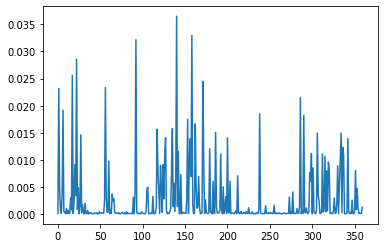

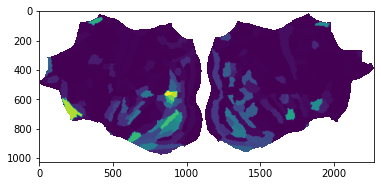

In [207]:
temp = np.mean(three_subs[:,0,0,:], axis=0)
plt.plot(temp)

plt.figure()
plt.imshow( get_flatmap(generate_plot( temp ))[0] , cmap='viridis') 
plt.show()

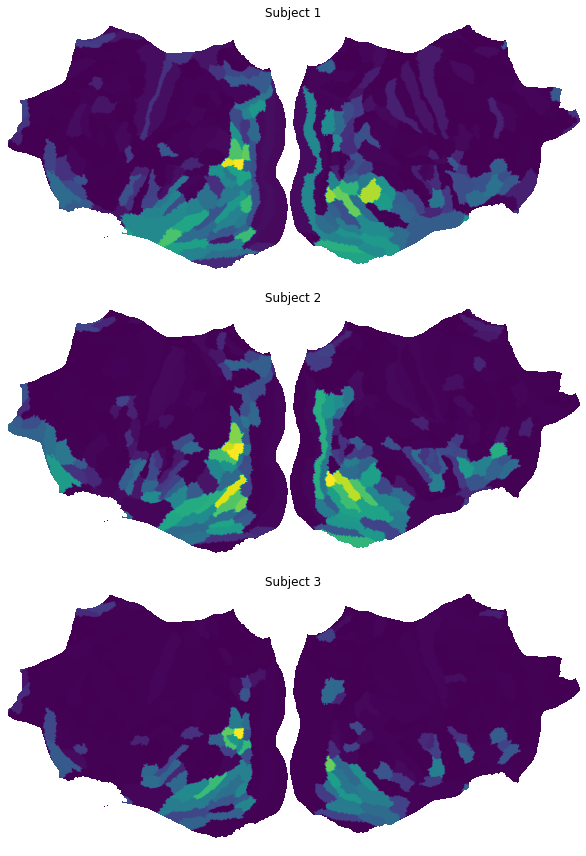

In [213]:
# Subjects 1 2 and 3 model

fig, ax = plt.subplots(3,1, figsize=(12,12))

trial = 3
timestep = 13

for i, a in enumerate(ax.flatten()):
    d = three_subs[i]#, trial, timestep]
    d = np.mean(d, axis=(0,1))
    a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"Subject {i+1}")
    
plt.tight_layout()
plt.show()

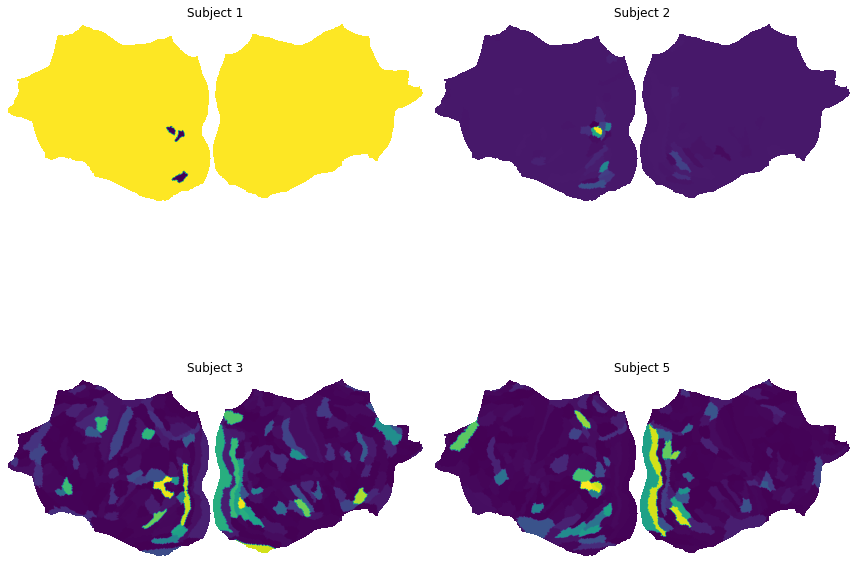

In [214]:
# 8 subjects

sub_ids = [1, 2, 3, 5, 6, 7]

fig, ax = plt.subplots(2,2, figsize=(12,12))

for i, a in enumerate(ax.flatten()):
    d = all_subs[i, 0, 0]
#     d = three_subs[i]
#     d = np.mean(d, axis=(0,1))
    a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"Subject {sub_ids[i]}")
    
plt.tight_layout()
plt.show()

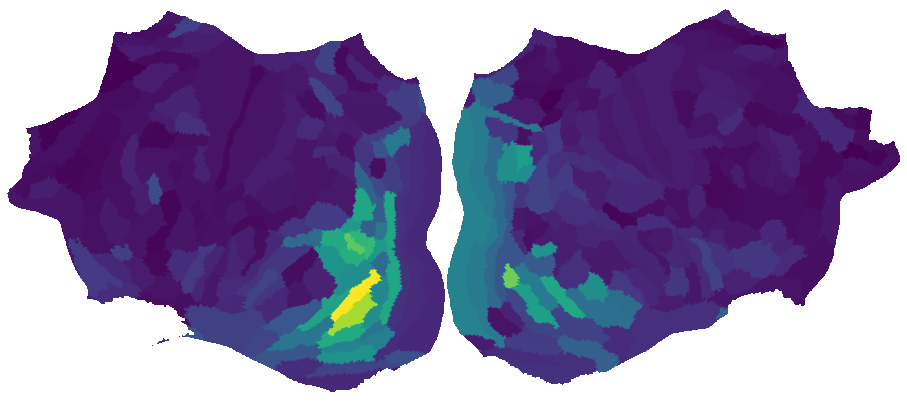

In [210]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
d = np.mean(all_subs, axis=(0,1,2))
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')
plt.show()

# Single subject maps

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

d = np.mean(sub5, axis=(0,1))
# d = sub1[0,0]
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

plt.show()

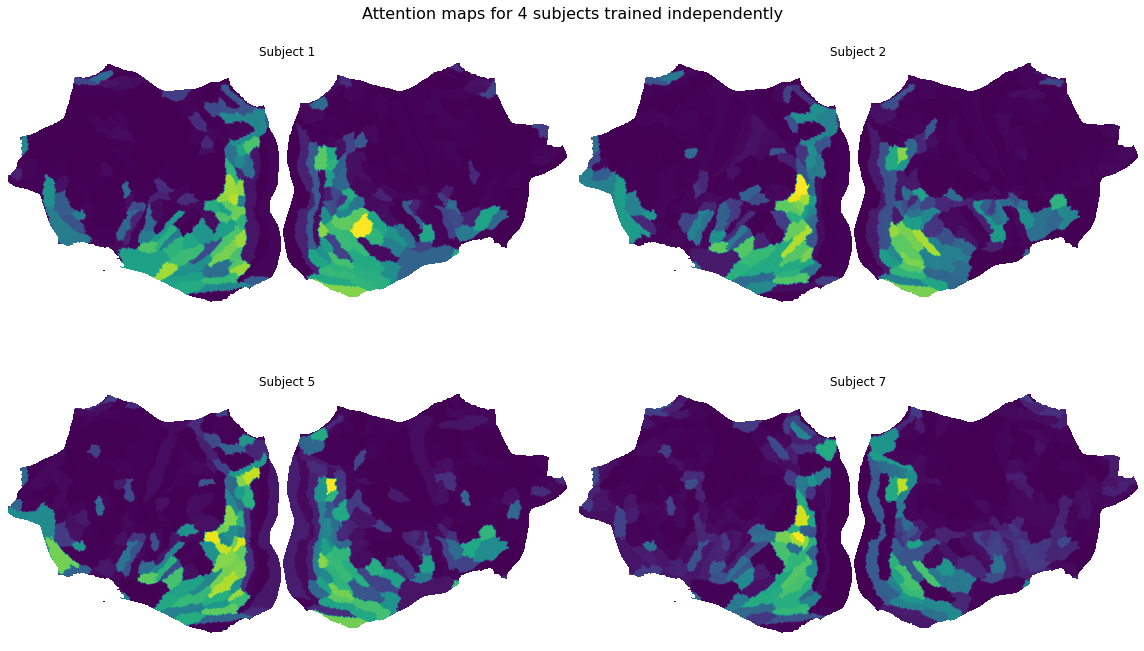

In [37]:
fig, ax = plt.subplots(2,2,figsize=(16,10))

d = np.mean(sub1, axis=(0,1))
ax[0,0].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[0,0].axis('off')
ax[0,0].set_title("Subject 1")

d = np.mean(sub2, axis=(0,1))
ax[0,1].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[0,1].axis('off')
ax[0,1].set_title("Subject 2")

d = np.mean(sub5, axis=(0,1))
ax[1,0].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[1,0].axis('off')
ax[1,0].set_title("Subject 5")

d = np.mean(sub7, axis=(0,1))
ax[1,1].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[1,1].axis('off')
ax[1,1].set_title("Subject 7")

plt.tight_layout()
plt.suptitle("Attention maps for 4 subjects trained independently", fontsize=16)
# plt.savefig("/home/hpcgies1/Masters-Thesis/AttemptFour/Plots/sub1_2_5_7_ln.png", bbox_inches='tight')
plt.show()

# No Layer Norm

In [8]:
sub2_no_norm = load_attn(get_attn_file('subject_2_no_norm'))

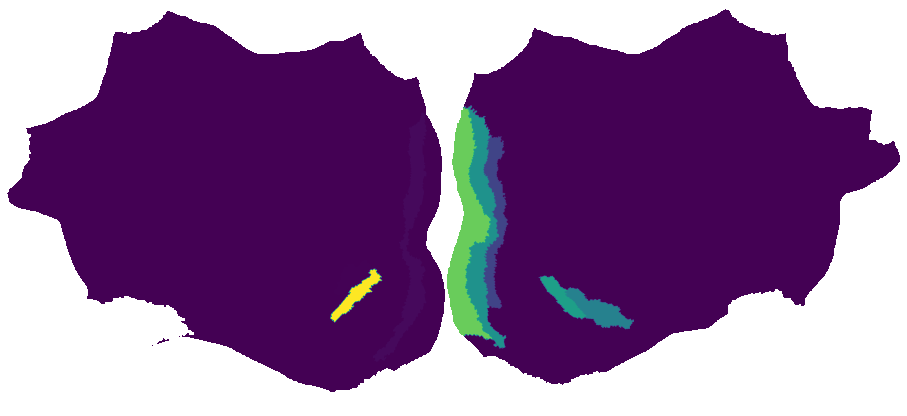

In [19]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

# d = np.mean(sub2_no_norm, axis=(0,1))
d = sub2_no_norm[40,1]
# d = np.log(d)
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

plt.show()

In [25]:
def idx_to_region(idx: int):
    """
    idx: int [0, 360)
    """
    df_regions = pd.read_csv("~/Masters-Thesis/AttemptFour/TrainData/unique_regions_list.csv")
    return df_regions.iloc[idx].regionLongName, df_regions.iloc[idx].regionName

In [33]:
d_idx = np.argsort(d)[::-1]
for i in range(10):
    print(i+1, "-", idx_to_region(d_idx[i])[0])

1 - Fusiform_Face_Complex_L
2 - Primary_Visual_Cortex_R
3 - Area_TE2_posterior_R
4 - Second_Visual_Area_R
5 - Area_TE2_anterior_R
6 - Third_Visual_Area_R
7 - Second_Visual_Area_L
8 - Area_PH_L
9 - Area_TE1_Middle_R
10 - Area_TemporoParietoOccipital_Junction_3_L
